In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torchvision import transforms
import matplotlib.pyplot as plt
from PIL import Image
from datasets import load_dataset, DatasetDict
from transformers import AutoImageProcessor, ViTForImageClassification, Trainer, TrainingArguments
import io

In [2]:
device='cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In this work, we will use the Vit model google/vit-base-patch16-224 for transfer learning on our dataset. 
This ViT model pretrained on ImageNet-21k (14milion images with 21843 classes) at resolution 224x224, and fine-tuned on ImageNet 2012 (1 milion images with 1000 classes) at resolution 224x224.

Loading dataset: Using Oxford-IIIT Pets Dataset with 37 classes on HunggingFace.


In [3]:
dts=load_dataset('pcuenq/oxford-pets')
dts

DatasetDict({
    train: Dataset({
        features: ['path', 'label', 'dog', 'image'],
        num_rows: 7390
    })
})

In [4]:
dts['train'][0]

{'path': '/data/datasets/magic-ml/oxford-iiit-pet/images/Siamese_137.jpg',
 'label': 'Siamese',
 'dog': False,
 'image': {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x08\x06\x06\x07\x06\x05\x08\x07\x07\x07\t\t\x08\n\x0c\x14\r\x0c\x0b\x0b\x0c\x19\x12\x13\x0f\x14\x1d\x1a\x1f\x1e\x1d\x1a\x1c\x1c $.\' ",#\x1c\x1c(7),01444\x1f\'9=82<.342\xff\xdb\x00C\x01\t\t\t\x0c\x0b\x0c\x18\r\r\x182!\x1c!22222222222222222222222222222222222222222222222222\xff\xc0\x00\x11\x08\x01\xf4\x01Y\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1f\x00\x00\x01\x05\x01\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x05\x06\x07\x08\t\n\x0b\xff\xc4\x00\xb5\x10\x00\x02\x01\x03\x03\x02\x04\x03\x05\x05\x04\x04\x00\x00\x01}\x01\x02\x03\x00\x04\x11\x05\x12!1A\x06\x13Qa\x07"q\x142\x81\x91\xa1\x08#B\xb1\xc1\x15R\xd1\xf0$3br\x82\t\n\x16\x17\x18\x19\x1a%&\'()*456789:CDEFGHIJSTUVWXYZcdefghijstuvwxyz\x83\x84\x85\x86\x87\x88\x89\x8a\x92\x93\x94\x95\x96\x97\

In [5]:
labels=dts['train'].unique('label')
labels

['Siamese',
 'Birman',
 'shiba inu',
 'staffordshire bull terrier',
 'basset hound',
 'Bombay',
 'japanese chin',
 'chihuahua',
 'german shorthaired',
 'pomeranian',
 'beagle',
 'english cocker spaniel',
 'american pit bull terrier',
 'Ragdoll',
 'Persian',
 'Egyptian Mau',
 'miniature pinscher',
 'Sphynx',
 'Maine Coon',
 'keeshond',
 'yorkshire terrier',
 'havanese',
 'leonberger',
 'wheaten terrier',
 'american bulldog',
 'english setter',
 'boxer',
 'newfoundland',
 'Bengal',
 'samoyed',
 'British Shorthair',
 'great pyrenees',
 'Abyssinian',
 'pug',
 'saint bernard',
 'Russian Blue',
 'scottish terrier']

Visualization dataset

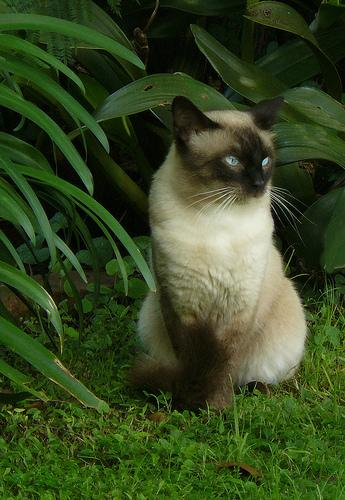

In [7]:
img_byte=dts['train'][0]['image']['bytes']
img=Image.open(io.BytesIO(img_byte))
img

In [8]:
dts['train'][0]

{'path': '/data/datasets/magic-ml/oxford-iiit-pet/images/Siamese_137.jpg',
 'label': 'Siamese',
 'dog': False,
 'image': {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x08\x06\x06\x07\x06\x05\x08\x07\x07\x07\t\t\x08\n\x0c\x14\r\x0c\x0b\x0b\x0c\x19\x12\x13\x0f\x14\x1d\x1a\x1f\x1e\x1d\x1a\x1c\x1c $.\' ",#\x1c\x1c(7),01444\x1f\'9=82<.342\xff\xdb\x00C\x01\t\t\t\x0c\x0b\x0c\x18\r\r\x182!\x1c!22222222222222222222222222222222222222222222222222\xff\xc0\x00\x11\x08\x01\xf4\x01Y\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1f\x00\x00\x01\x05\x01\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x05\x06\x07\x08\t\n\x0b\xff\xc4\x00\xb5\x10\x00\x02\x01\x03\x03\x02\x04\x03\x05\x05\x04\x04\x00\x00\x01}\x01\x02\x03\x00\x04\x11\x05\x12!1A\x06\x13Qa\x07"q\x142\x81\x91\xa1\x08#B\xb1\xc1\x15R\xd1\xf0$3br\x82\t\n\x16\x17\x18\x19\x1a%&\'()*456789:CDEFGHIJSTUVWXYZcdefghijstuvwxyz\x83\x84\x85\x86\x87\x88\x89\x8a\x92\x93\x94\x95\x96\x97\

In [9]:
def show_samples(data, rows, cols):
    samples=data.shuffle().select(range(rows*cols))
    plt.subplots(rows, cols,figsize=(rows*4,cols*4))
    for i in range(rows*cols):
        img_byte=samples[i]['image']['bytes']
        img=Image.open(io.BytesIO(img_byte))
        plt.subplot(rows, cols, i+1)
        plt.imshow(img)
        plt.title(samples[i]['label'])

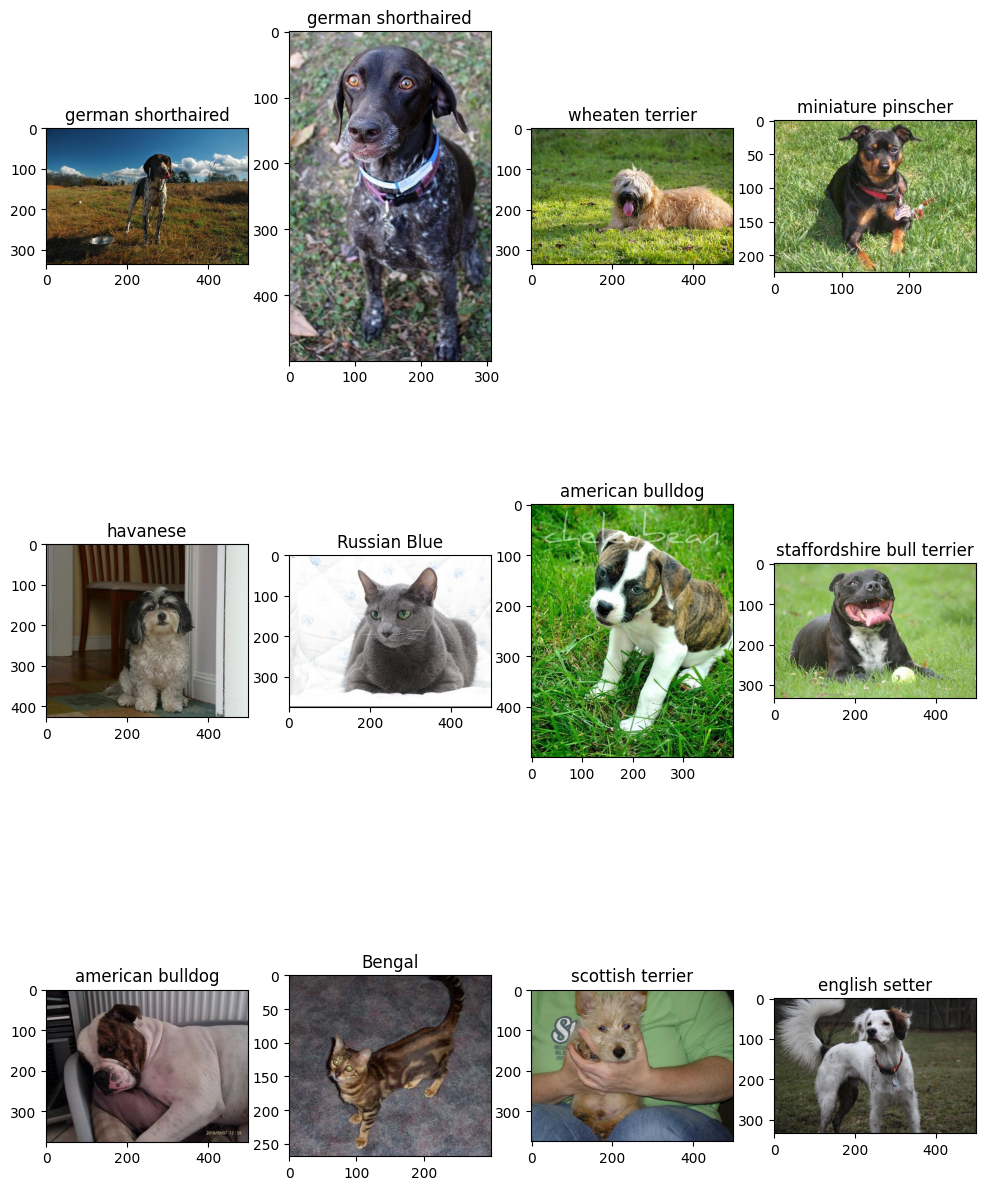

In [10]:
show_samples(dts['train'],3,4)

In [51]:
dts_split=dts['train'].train_test_split(test_size=0.2)
eval_split=dts_split['test'].train_test_split(test_size=0.5)

In [54]:
dts=DatasetDict({
    'train': dts_split['train'],
    'test':eval_split['train'],
    'validation': eval_split['test']
})
dts

DatasetDict({
    train: Dataset({
        features: ['path', 'label', 'dog', 'image'],
        num_rows: 5912
    })
    test: Dataset({
        features: ['path', 'label', 'dog', 'image'],
        num_rows: 739
    })
    validation: Dataset({
        features: ['path', 'label', 'dog', 'image'],
        num_rows: 739
    })
})

Processing dataset

In [12]:
model_id='google/vit-base-patch16-224'
processor=AutoImageProcessor.from_pretrained(model_id)

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


In [13]:
label2id={lb:idx for idx, lb in enumerate(labels)}
id2label={idx:lb for idx, lb in enumerate(labels)}

In [14]:
processor

ViTImageProcessor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [63]:
def transform(data):
    data['image']=[Image.open(io.BytesIO(x['bytes'])).convert('RGB') for x in data['image']]
    inputs=processor(data['image'], return_tensors='pt')
    inputs['label']=[label2id[y] for y in data['label']]
    return inputs

In [64]:
dataset_proc=dts.with_transform(transform)

In [65]:
dataset_proc=dataset_proc.remove_columns(column_names=['path', 'dog'])

In [66]:
dataset_proc

DatasetDict({
    train: Dataset({
        features: ['label', 'image'],
        num_rows: 5912
    })
    test: Dataset({
        features: ['label', 'image'],
        num_rows: 739
    })
    validation: Dataset({
        features: ['label', 'image'],
        num_rows: 739
    })
})

Data collation

In [67]:
def data_collator(batch):
    return {'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
            'labels': torch.tensor([x['label'] for x in batch])
            }

Metric

In [68]:
import evaluate
accuracy=evaluate.load('accuracy')
def metric(pred):
    logits, labels=pred
    prediction=np.argmax(logits, axis=1)
    score=accuracy.compute(predictions=prediction, references=labels)
    return score

Loading model

In [69]:
model=ViTForImageClassification.from_pretrained(
    model_id,
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True
).to(device)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([37]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([37, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [24]:
#Architecture of model
model

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

In [25]:
#Transfer learning
for name, p in model.named_parameters():
    if not name.startswith('classifier'):
        p.requires_grad=False

In [26]:
num_params=sum([p.numel() for p in model.parameters()])
trainable_params=sum([p.numel() for p in model.parameters() if p.requires_grad])
print(f'Number of params: {num_params}')
print(f'Num trainable params: {trainable_params}')

Number of params: 85827109
Num trainable params: 28453


Training

In [70]:
training_args=TrainingArguments(
    output_dir='./transfer_learning_clf',
    per_device_eval_batch_size=8,
    eval_strategy='epoch',
    num_train_epochs=5,
    remove_unused_columns=False,
)

In [71]:
trainer=Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    compute_metrics=metric,
    train_dataset=dataset_proc['train'],
    eval_dataset=dataset_proc['test'],
    tokenizer=processor

)

/tmp/ipykernel_4829/3080408445.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer=Trainer(


In [ ]:
trainer.train()

In [32]:
trainer.save_model('./ViT_transfer')

Validation

In [28]:
#Loading model
model_load=ViTForImageClassification.from_pretrained('ViT_transfer').to(device)

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

Visualization

In [48]:
def results(samples, rows, cols):
    samples=samples.shuffle().select(range(rows*cols))
    inputs=samples.with_transform(transform)
    output=model_load(inputs[:rows*cols]['pixel_values'].to(device)).logits
    output=np.argmax(output.detach().cpu().numpy(), axis=-1)
    print(output[0])
    plt.subplots(rows, cols,figsize=(rows*4,cols*4))
    for i in range(rows*cols):
        img_byte=samples[i]['image']['bytes']
        img=Image.open(io.BytesIO(img_byte))
        plt.subplot(rows, cols, i+1)
        plt.imshow(img)
        plt.title(f'Pred: {id2label[output[i]]} \nLabel: {samples[i]['label']}')

33


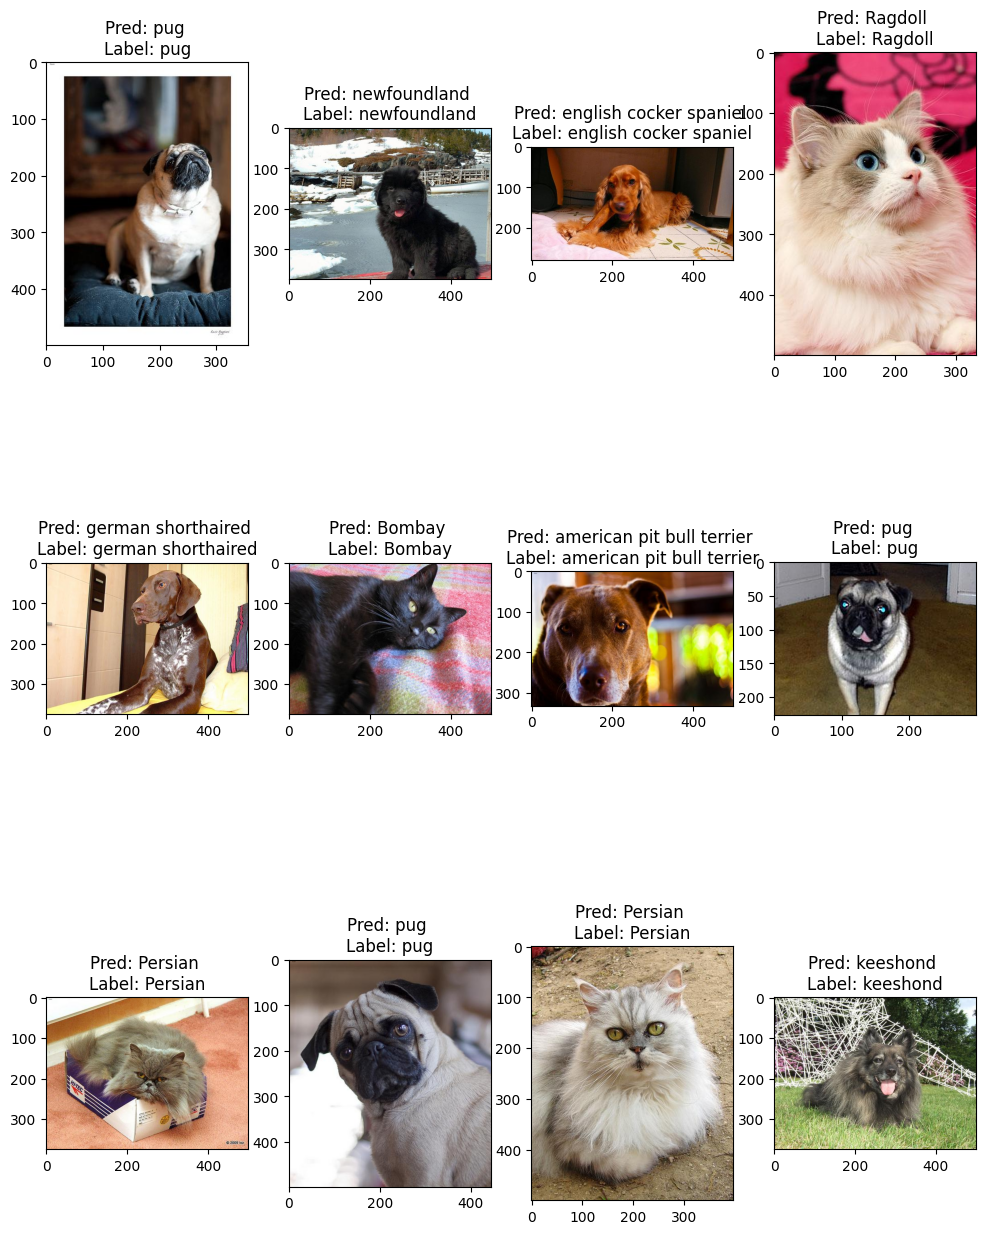

In [73]:
results(dts['validation'], 3, 4)